# Programming assignment 4: Convolutional Neural Networks (100 points)
(adapted from the work done by Erik Learned-Miller, which was originally developed by Fei-Fei Li, Andrej Karpathy, and Justin Johnson)

## Overview
<font size='4'> In this assignment you will practice putting together a Convolution Neural Network (CNN) classification pipeline. So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

<font size='4'>In this assignment, you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

## Submission format
* <font size='4'>`<your_nu_username>_pa4.ipynb`
    
## Note: 
* <font size='4'>Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that’s not in there by default will probably cause your code to break during grading. Failure to follow any of these instructions will lead to point deductions. 
* <font size='4'>We have some inline questions embedded in the Jupyter notebook files. Do not miss them.
* <font size='4' color='red'>Unless specified otherwise, no for loops are allowed.

## setup

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
# from utils.classifiers.fc_net import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# You implemented such functions in PA3. Here are some reference implementations.
from utils.layers import affine_forward, affine_backward, relu_forward, relu_backward, softmax_loss

In [8]:
# let's download the data
%cd ../datasets

# 1 -- Linux 
# 2 -- MacOS
# 3 -- Command Prompt on Windows
# 4 -- manually downloading the data
choice = 3


if choice == 1:
    # should work well on Linux and in Powershell on Windows
    !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
elif choice == 2 or choice ==3:
    # if wget is not available for you, try curl
    # should work well on MacOS
    !curl http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz --output cifar-10-python.tar.gz
else:
    print('Please manually download the data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and put it under the datasets folder.')
!tar -xzvf cifar-10-python.tar.gz

if choice==3:
    !del cifar-10-python.tar.gz
else:
    !rm cifar-10-python.tar.gz

c:\Users\ashwi\OneDrive - Northeastern University\Documents\RL CS5180\pa4\datasets


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  162M    0  671k    0     0  1202k      0  0:02:18 --:--:--  0:02:18 1203k
  1  162M    1 3058k    0     0  1279k      0  0:02:10  0:00:02  0:02:08 1279k
  1  162M    1 3058k    0     0   899k      0  0:03:05  0:00:03  0:03:02  900k
  1  162M    1 3058k    0     0   694k      0  0:03:59  0:00:04  0:03:55  694k
  1  162M    1 3062k    0     0   640k      0  0:04:19  0:00:04  0:04:15  640k
  3  162M    3 6231k    0     0  1123k      0  0:02:28  0:00:05  0:02:23 1114k
  5  162M    5 9381k    0     0  1433k      0  0:01:56  0:00:06  0:01:50 1521k
  7  162M    7 12.3M    0     0  1669k      0  0:01:39  0:00:07  0:01:32 2298k
  9  162M    9 15.7M    0     0  1891k      0  0:01:28  0:00:08  0:01:20 3161k
 12  162M   12 20.0M    0     0  2147k      0  0:01

In [93]:
# Load the (preprocessed) CIFAR10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'

data = get_CIFAR10_data(cifar10_dir)
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


## Part 1: Convolution layers (20 points)

<font size="4" color="red">**task 1.1: forward pass of a convolution layer. At most two nested for loops are allowed (10 points).**

In [14]:
def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.


    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    
    
    ###########################################################################
    # TODO: Implement the convolutional forward pass.                         #
    # Hint: you can use the function np.pad for padding.                      #
    ###########################################################################

    (N, C, H, W) = x.shape
    (F, C, HH, WW) = w.shape
    pad = conv_param['pad']
    stride = conv_param["stride"]
    Hout =  int(1 + (H + 2 * pad - HH)/stride) 
    Wout =  int(1 + (W + 2 * pad - WW)/stride)

    out = np.zeros(shape=(N, F, Hout, Wout))
    
    x_padded = np.pad(x, [(0,0), (0, 0), (pad, pad), (pad, pad)], mode='constant', constant_values = 0)
    w_reshape = w.reshape(F,-1).T
    
    for i in range(Hout):
      for j in range(Wout):
        patch = x_padded[:,:,i*stride:i*stride+HH,j*stride:j*stride+WW]
        pt = patch.reshape(N,-1)
        out[:,:,i,j] = np.dot(pt,w_reshape)+b

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    cache = (x, w, b, conv_param)
    return out, cache

In [15]:
# check your forward pass implementation
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476575931688e-08


<font size="4" color="red">**task 1.2: backward pass of a convolution layer. At most two nested for loops are allowed (10 points).**

In [16]:
def conv_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    dx, dw, db = None, None, None
    
    ###########################################################################
    # TODO: Implement the convolutional backward pass.                        #
    ###########################################################################
    x, w, b, conv_param = cache

    #print(x.shape)
    #print(w.shape)
    pad = conv_param['pad']
    stride = conv_param["stride"]

    x_padded = np.pad(x, [(0,0), (0, 0), (pad, pad), (pad, pad)], mode='constant', constant_values = 0)
    (N, C, H, W) = x_padded.shape
    (F, C, HH, WW) = w.shape
    Hout =  int(1 + (H - HH)/stride)
    Wout =  int(1 + (W - WW)/stride)

    dx, dw, db = np.zeros(x_padded.shape), np.zeros(w.shape), np.sum(dout, axis = (0, 2, 3))
    
    for single in range(N):
        for filt in range(F):
            for number in range(Hout*Wout):
                out_h = number//Wout
                out_w = number%Wout

                current_dout = dout[single, filt, out_h, out_w]
                #print(current_dout)
                current_w = w[filt, :, :, :]
                current_x = x_padded[single, :, out_h*stride : out_h*stride + HH, out_w*stride:out_w*stride+WW]
                #print(current_x.shape)
                dx[single, :, out_h*stride : out_h*stride + HH, out_w*stride:out_w*stride+WW] += current_w*current_dout
                #print(current_x*current_dout.shape)
                dw[filt,:,:,:] += current_x*current_dout
            
    dx = dx[:, :, pad:-pad, pad:-pad]
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return dx, dw, db

In [17]:
# gradient check
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  7.99015495883212e-09
dw error:  2.678251086979749e-10
db error:  3.8835192329918934e-11


## Part 2: Spatial Batch Normalization (32 points)
<font size='4'>Batch normalization is a very useful technique for training deep neural networks. As proposed in the original paper [1], batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

<font size='4'>Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

<font size='4'>If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

<font size='4' color='red'>**Task 2.1: forward pass of a (normal) batch norm layer (10 points).**

In [77]:
def batchnorm_forward(x, gamma, beta, bn_param,n = 0):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the PyTorch
    implementation of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean'+str(n), np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var'+str(n), np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        #######################################################################
        # TODO: Implement the training-time forward pass for batch norm.      #
        # Use minibatch statistics to compute the mean and variance, use      #
        # these statistics to normalize the incoming data, and scale and      #
        # shift the normalized data using gamma and beta. Simply treat the    #
        # sample mean and sample variance as constants to simplify the        #
        # gradients computation.                                              #
        #                                                                     #
        # You should store the output in the variable out. Any intermediates  #
        # that you need for the backward pass should be stored in the cache   #
        # variable.                                                           #
        #                                                                     #
        # You should also use your computed sample mean and variance together #
        # with the momentum variable to update the running mean and running   #
        # variance, storing your result in the running_mean and running_var   #
        # variables.                                                          #
        #                                                                     #
        # Note that though you should be keeping track of the running         #
        # variance, you should normalize the data based on the standard       #
        # deviation (square root of variance) instead!                        #
        # Referencing the original paper (https://arxiv.org/abs/1502.03167)   #
        # might prove to be helpful.                                          #
        #######################################################################
        mean = np.mean(x, axis = 0)
        var = np.var(x, axis = 0)
        x_norm = (x-mean)/np.sqrt(var+eps)

        running_mean = momentum*running_mean+(1-momentum)*mean
        running_var = momentum*running_var+(1-momentum)*var

        out = x_norm*gamma + beta
        cache = (eps,gamma,mean,var,x,x_norm)
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test-time forward pass for batch normalization. #
        # Use the running mean and variance to normalize the incoming data,   #
        # then scale and shift the normalized data using gamma and beta.      #
        # Store the result in the out variable.                               #
        #######################################################################
        out = gamma*(x-running_mean)/np.sqrt(eps+running_var)+beta
        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'+str(n)] = running_mean
    bn_param['running_var'+str(n)] = running_var

    return out, cache

<font size='4' color='red'>**Task 2.2: forward pass of a spatial batch norm layer (6 points).**

In [78]:
def spatial_batchnorm_forward(x, gamma, beta, bn_param,n=0):
    """
    Computes the forward pass for spatial batch normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance. momentum=0 means that
        old information is discarded completely at every time step, while
        momentum=1 means that new information is never incorporated. The
        default of momentum=0.9 should work well in most situations.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    out, cache = None, None

    ###########################################################################
    # TODO: Implement the forward pass for spatial batch normalization.       #
    #                                                                         #
    # HINT: You can implement spatial batch normalization by calling the      #
    # vanilla version of batch normalization you implemented above.           #
    # Your implementation should be very short; ours is less than five lines. #
    ###########################################################################
    #raise NotImplementedError
    #
    (N,C,H,W) = x.shape
    x_trans = x.transpose((0,2,3,1))
    trans_out, cache = batchnorm_forward(x_trans.reshape(-1,C), gamma, beta, bn_param,n=n)
    trans_out = trans_out.reshape(x_trans.shape)
    out = trans_out.transpose((0,3,1,2))
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return out, cache

In [79]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [9.33463814 8.90909116 9.11056338]
  Stds:  [3.61447857 3.19347686 3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.18949336e-16  5.99520433e-16 -1.22124533e-16]
  Stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999885 3.99999804 4.99999798]


In [80]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))
print('  cache: ', cache)

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [0.96718744 1.0299714  1.02887624 1.00585577]
  cache:  None


<font size='4' color='red'>**Task 2.3: backward pass of a (normal) batch norm layer (10 points).**

In [81]:
def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.
    
    For this implementation you should work out the derivatives for the batch
    normalizaton backward pass on paper and simplify as much as possible. You
    should be able to derive a simple expression for the backward pass.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    #                                                                         #
    # After computing the gradient with respect to the centered inputs, you   #
    # should be able to compute gradients with respect to the inputs in a     #
    # single statement.                                                       #
    ###########################################################################
    eps,gamma,mean,var,x,x_norm = cache
    
    N = x.shape[0]
    dbeta = np.sum(dout, axis = 0)
    dgamma = np.sum(np.multiply(dout,x_norm),axis = 0)
    xgrad = dout*gamma
    vargrad = np.sum(np.multiply(np.multiply(xgrad,x-mean),(-0.5)*((var+eps)**(-1.5))), axis = 0)
    meangrad = np.sum(xgrad*-1/np.sqrt(var+eps), axis = 0) + vargrad*(np.sum(-2.0*(x-mean), axis = 0))/N
    dx = xgrad/np.sqrt(var+eps) + vargrad*(2*x-2*mean)/N +meangrad/N
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta

<font size='4' color='red'>**Task 2.4: backward pass of a spatial batch norm layer (6 points).**

In [82]:
def spatial_batchnorm_backward(dout, cache):
    """
    Computes the backward pass for spatial batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient with respect to inputs, of shape (N, C, H, W)
    - dgamma: Gradient with respect to scale parameter, of shape (C,)
    - dbeta: Gradient with respect to shift parameter, of shape (C,)
    """
    dx, dgamma, dbeta = None, None, None

    ###########################################################################
    # TODO: Implement the backward pass for spatial batch normalization.      #
    #                                                                         #
    # HINT: You can implement spatial batch normalization by calling the      #
    # vanilla version of batch normalization you implemented above.           #
    # Your implementation should be very short; ours is less than five lines. #
    ###########################################################################
    
    (N,C,H,W) = dout.shape
    x_trans = dout.transpose((0,2,3,1))
    dx_trans,dgamma,dbeta = batchnorm_backward(x_trans.reshape(-1,C), cache)
    dx_trans = dx_trans.reshape(x_trans.shape)
    dx = dx_trans.transpose((0,3,1,2))
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta

In [83]:
# gradient check
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.786648197756335e-07
dgamma error:  7.0974817113608705e-12
dbeta error:  3.275608725278405e-12


## Part 3: Global average pooling layer (12 points)
<font size='4'> In AlexNet and VGG-like networks, a 2D convolution feature map is usually flattened to get a 1D feature vector, which is then fed into a fully-connected layer. Since ResNet, such flattening is no longer used. Instead, an global average pooing layer is used. Given a 2D feature map with shape of `(N, C, H, W)`, the mean across the dimension `H` and `W` are computed. As a result, we get a 2D feature map with shape of `(N, C, 1, 1)` that is equivalent to a 1D feature vector with shape of `(N, C)`.

<font size='4' color='red'>**Task 3.1: forward pass of the global average pooling layer (6 points).**

In [84]:
def global_avg_pool_forward(x):
    """
    Computes the forward pass of the global average pooling layer
    
    Input:
    - x: Input data of shape (N, C, H, W)
    
    Returns of a tuple of:
    - out: Output data, of shape (N, C)
    - cache: (x,)
    """
    out, cache = None, None
    
    ###########################################################################
    # TODO: Implement the forward pass for global average pooling.            #
    ###########################################################################
    out = np.mean(x,axis=(2,3))
    cache = x
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return out, cache

In [85]:
# check your implementation
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)

out, _ = global_avg_pool_forward(x)
correct_out = np.array([
    [-0.05263158,  0.04842105,  0.14947368],
    [ 0.25052632,  0.35157895,  0.45263158]
])

# Compare your output to ours; difference should be around e-8
print('Testing global_avg_pool_forward')
print('difference: ', rel_error(out, correct_out))

Testing global_avg_pool_forward
difference:  2.7173913643149127e-08


<font size='4' color='red'>**Task 3.2: backward pass of the global average pooling layer (6 points).**

In [86]:
def global_avg_pool_backward(dout, cache):
    """
    Computes the forward pass of the global average pooling layer
    
    Inputs:
    - dout: Upstream derivatives.
    - cache: x as in global_avg_pool_backward
    
    Returns:
    - dx: gradient with respect x
    
    """
    dx = None
    
    ###########################################################################
    # TODO: Implement the backward pass for global average pooling.           #
    ###########################################################################
    N,C,H,W = cache.shape
    dout = dout.reshape(N,C,1,1)
    grad = np.ones((N,C,H,W))/(H*W)
    dx = np.multiply(grad,dout)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return dx    

In [87]:
# gradient check
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
dout = np.random.randn(4, 3)

dx_num = eval_numerical_gradient_array(lambda x: global_avg_pool_forward(x)[0], x, dout)

out, cache = global_avg_pool_forward(x)
dx = global_avg_pool_backward(dout, cache)

# Your errors should be around e-8 or less.
print('Testing global_avg_pool_backward function')
print('dx error: ', rel_error(dx, dx_num))

Testing global_avg_pool_backward function
dx error:  5.501121908575301e-11


In [88]:
"""CODE TAKEN FROM PA3 TO USE IN TASK:4"""

def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    
    #print(x.shape)
    minibatch = x.shape[0]
    imgvector = np.prod(x.shape[1:]) 
    xlinear = x.reshape(minibatch, imgvector)
    out = np.dot(xlinear, w) + b
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache

def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    dx = dout.dot(w.T).reshape(x.shape)
    xlinear = x.reshape(x.shape[0], np.prod(x.shape[1:]))
    dw = xlinear.T.dot(dout)
    db = np.sum(dout, axis=0)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    
    zs = np.zeros(x.shape,int)
    out = np.maximum(zs,x)
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache

def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    out,_ = relu_forward(x)
    out[out > 0] = 1
    dx = out*dout

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx


In [89]:
"""CODE TAKEN FROM PA3 TO USE IN TASK:4"""

def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to y
    """
    
    loss, dx = None, None

    ###########################################################################
    # TODO: Implement the softmax_loss function,                              #
    # including the forward and backward passes.                              #
    ###########################################################################
    #overflow control
    overflow = x- np.max(x, axis=1, keepdims=True)
    miniclass = np.exp(overflow)
    softminibatch = miniclass/np.sum(miniclass, axis=1, keepdims=True)
    loss  = -np.sum(np.log(softminibatch[np.arange(x.shape[0]),y]))/x.shape[0]
    #dx of loss vector
    softminibatch[np.arange(x.shape[0]),y] -= 1
    dx = softminibatch/x.shape[0]
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return loss, dx



## Part 4: ConvNet (36 points)
<font size='4'>Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

<font size='4' color='red'>**Task 4.1: Implement a CNN. No nested for loops are allowed. You may need to use a single for loop at multiple places (20 points).**

In [90]:
class ConvNet(object):
    """
    A simple convolutional network with the following architecture:

    [conv - bn - relu] x M - global_average_pooling - affine - softmax
    
    "[conv - bn - relu] x M" means the "conv-bn-relu" block is repeated for
    M times, where M is implicitly defined by the convolution layers' parameters.
    Whether to use the batch normalization layer (bn) in-between is a design choice.
    
    For each convolution layer, we do downsampling of factor 2 by setting the stride
    to be 2. So we can have a large receptive field size.

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(self, input_dim=(3, 32, 32), num_filters=[32], filter_sizes=[7],
            num_classes=10, weight_scale=1e-3, reg=0.0, use_batch_norm=True, 
            dtype=np.float32):
        """
        Initialize a new network.

        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - num_filters: Number of filters to use in the convolutional layer. It is a
          list whose length defines the number of convolution layers
        - filter_sizes: Width/height of filters to use in the convolutional layer. It
          is a list with the same length with num_filters
        - num_classes: Number of output classes
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength
        - use_batch_norm: A boolean variable indicating whether to use batch normalization
        - dtype: numpy datatype to use for computation.
        """
        self.params = {}
        self.reg = reg
        self.dtype = dtype
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.use_batch_norm = use_batch_norm
        self.num_classes = num_classes
        self.input_dim = np.array(input_dim,int)
        assert len(num_filters) == len(filter_sizes)

        ############################################################################
        # TODO: Initialize weights and biases for the simple convolutional         #
        # network. Weights should be initialized from a Gaussian centered at 0.0   #
        # with standard deviation equal to weight_scale; biases should be          #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params.                                                 #
        #                                                                          #
        # IMPORTANT:                                                               #
        # 1. For this assignment, you can assume that the padding                  #
        # and stride of the first convolutional layer are chosen so that           #
        # **the width and height of the input are preserved**. You need to         #
        # carefully set the `pad` parameter for the convolution.                   #
        #                                                                          #
        # 2. For each convolution layer, we use stride of 2 to do downsampling.    #
        ############################################################################
        self.conv_params = {}
        self.conv_params['pad'] = 1
        self.conv_params['stride'] = 2#***
        i = 0
        channels = self.input_dim.shape[0]
        for  dim in range(len(num_filters)):
          self.params['b'+str(i+1)] = weight_scale*np.zeros(num_filters[dim])
          self.params['W'+str(i+1)] = weight_scale*np.random.randn(num_filters[dim],channels,filter_sizes[dim],filter_sizes[dim])
          
          channels = num_filters[dim]
          if self.use_batch_norm :
            self.params['beta'+str(i+1)] = weight_scale*np.random.randn(channels)
            self.params['gamma'+str(i+1)] = weight_scale*np.random.randn(channels)
            
          i += 1

        self.params['b'+str(i+1)] = weight_scale*np.zeros(num_classes)
        self.params['W'+str(i+1)] = weight_scale*np.random.randn(channels,num_classes)
        



        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the simple convolutional network.

        Inputs:
        - X: Array of input data of shape (N, C, H, W)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """

        scores = None
        mode = 'test' if y is None else 'train'
        ############################################################################
        # TODO: Implement the forward pass for the simple convolutional net,       #
        # computing the class scores for X and storing them in the scores          #
        # variable.                                                                #
        ############################################################################
        self.conv_params['mode'] = mode
        cachelayers = {}
        
        layer_input = X
        
        for num in list(range(len(self.num_filters))):
          layer_input,cachelayers['conv'+str(num+1)] = conv_forward_naive(layer_input,self.params['W'+str(num+1)],self.params['b'+str(num+1)],self.conv_params)
          
          if self.use_batch_norm :
            layer_input,cachelayers['bn'+str(num+1)] = spatial_batchnorm_forward(layer_input,self.params['gamma'+str(num+1)],self.params['beta'+str(num+1)],self.conv_params,n = num)
          layer_input,cachelayers['relu'+str(num+1)] = relu_forward(layer_input)
          
        layer_input1,cachelayers['gvp'] = global_avg_pool_forward(layer_input)
        
        scores,cachelayers['affine'] = affine_forward(layer_input1,self.params['W'+str(len(self.num_filters)+1)],self.params['b'+str(len(self.num_filters)+1)])
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the simple convolutional net,      #
        # storing the loss and gradients in the loss and grads variables. Compute  #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        
        loss,dx = softmax_loss(scores,y)
        loss += (self.reg*np.sum(np.square(self.params['W'+str(len(self.num_filters)+1)])))/2
        dx1,dw,db = affine_backward(dx,cachelayers['affine'])
        grads['W'+str(len(self.num_filters)+1)] = dw + self.reg*self.params['W'+str(len(self.num_filters)+1)]
        grads['b'+str(len(self.num_filters)+1)] = db

        dx = global_avg_pool_backward(dx1,cachelayers['gvp'])

        lst = list(range(len(self.num_filters)))
        lst.reverse()

        for ele in lst:
          
          dx = relu_backward(dx,cachelayers['relu'+str(ele+1)])
          if self.use_batch_norm :
            dx,dgamma,dbeta = spatial_batchnorm_backward(dx,cachelayers['bn'+str(ele+1)])
            grads['beta'+str(ele+1)] = dbeta+self.reg*self.params['beta'+str(ele+1)]
            grads['gamma'+str(ele+1)] = dgamma+self.reg*self.params['gamma'+str(ele+1)]
          
          loss += (self.reg*np.sum(np.square(self.params['W'+str(ele+1)])))/2
          dx,dw,db = conv_backward_naive(dx,cachelayers['conv'+str(ele+1)])
          grads['W'+str(ele+1)] = dw+self.reg*self.params['W'+str(ele+1)]
          grads['b'+str(ele+1)] = db



        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


### Sanity check loss
<font size='4'>After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [33]:
model = ConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)
print('log(10): ', np.log(10))

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302585145354021
log(10):  2.302585092994046
Initial loss (with regularization):  2.3038438678968642


### Gradient check
<font size='4'>After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to the order of e-2.

In [34]:
num_inputs = 2
input_dim = (3, 8, 8)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ConvNet(input_dim=input_dim, dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 2.999253e-02
W2 max relative error: 3.780919e-04
b1 max relative error: 9.317362e-13
b2 max relative error: 8.484904e-10
beta1 max relative error: 1.982488e-04
gamma1 max relative error: 1.901789e-05


### Overfit small data
<font size='4'>A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in high training accuracy and comparatively low validation accuracy.

<font size='4'>Here, due to the limited training epochs, we are not really able to overfit the training data with a 100% training accuracy. You should be able to achieve around 50% training accuracy and 19% validation accuracy.

In [511]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ConvNet(
    num_filters=[16, 32],
    filter_sizes=[3, 3],
    weight_scale=1
)

solver = Solver(
    model, small_data,
    num_epochs=50, batch_size=20,
    update_rule='sgd_momentum',
    optim_config={
      'learning_rate': .1,
    },
    verbose=True, print_every=5
)
solver.train()

(Iteration 1 / 250) loss: 7.414994
(Epoch 0 / 50) train acc: 0.100000; val_acc: 0.118000
(Epoch 1 / 50) train acc: 0.120000; val_acc: 0.166000
(Epoch 2 / 50) train acc: 0.190000; val_acc: 0.184000
(Iteration 11 / 250) loss: 2.377068
(Epoch 3 / 50) train acc: 0.170000; val_acc: 0.129000
(Epoch 4 / 50) train acc: 0.220000; val_acc: 0.122000
(Iteration 21 / 250) loss: 2.220213
(Epoch 5 / 50) train acc: 0.200000; val_acc: 0.148000
(Epoch 6 / 50) train acc: 0.200000; val_acc: 0.137000
(Iteration 31 / 250) loss: 2.018713
(Epoch 7 / 50) train acc: 0.250000; val_acc: 0.153000
(Epoch 8 / 50) train acc: 0.310000; val_acc: 0.181000
(Iteration 41 / 250) loss: 2.135087
(Epoch 9 / 50) train acc: 0.330000; val_acc: 0.184000
(Epoch 10 / 50) train acc: 0.300000; val_acc: 0.145000
(Iteration 51 / 250) loss: 1.894962
(Epoch 11 / 50) train acc: 0.320000; val_acc: 0.146000
(Epoch 12 / 50) train acc: 0.350000; val_acc: 0.165000
(Iteration 61 / 250) loss: 2.029767
(Epoch 13 / 50) train acc: 0.330000; val_acc

In [44]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ConvNet(
    num_filters=[16, 32, 64],
    filter_sizes=[3, 3, 3],
    weight_scale=.75
)

solver = Solver(
    model, small_data,
    num_epochs=50, batch_size=32,
    update_rule='sgd_momentum',
    optim_config={
      'learning_rate': .0675,
    },
    verbose=True, print_every=5
)
solver.train()

(Iteration 1 / 150) loss: 8.405891
(Epoch 0 / 50) train acc: 0.060000; val_acc: 0.109000
(Epoch 1 / 50) train acc: 0.050000; val_acc: 0.095000
(Iteration 6 / 150) loss: 3.747050
(Epoch 2 / 50) train acc: 0.080000; val_acc: 0.121000
(Epoch 3 / 50) train acc: 0.080000; val_acc: 0.099000
(Iteration 11 / 150) loss: 2.682948
(Epoch 4 / 50) train acc: 0.100000; val_acc: 0.084000
(Epoch 5 / 50) train acc: 0.180000; val_acc: 0.135000
(Iteration 16 / 150) loss: 2.260960
(Epoch 6 / 50) train acc: 0.180000; val_acc: 0.125000
(Iteration 21 / 150) loss: 2.729805
(Epoch 7 / 50) train acc: 0.170000; val_acc: 0.133000
(Epoch 8 / 50) train acc: 0.110000; val_acc: 0.123000
(Iteration 26 / 150) loss: 2.228246
(Epoch 9 / 50) train acc: 0.280000; val_acc: 0.148000
(Epoch 10 / 50) train acc: 0.280000; val_acc: 0.145000
(Iteration 31 / 150) loss: 2.414542
(Epoch 11 / 50) train acc: 0.340000; val_acc: 0.142000
(Iteration 36 / 150) loss: 2.176486
(Epoch 12 / 50) train acc: 0.360000; val_acc: 0.135000
(Epoch 13

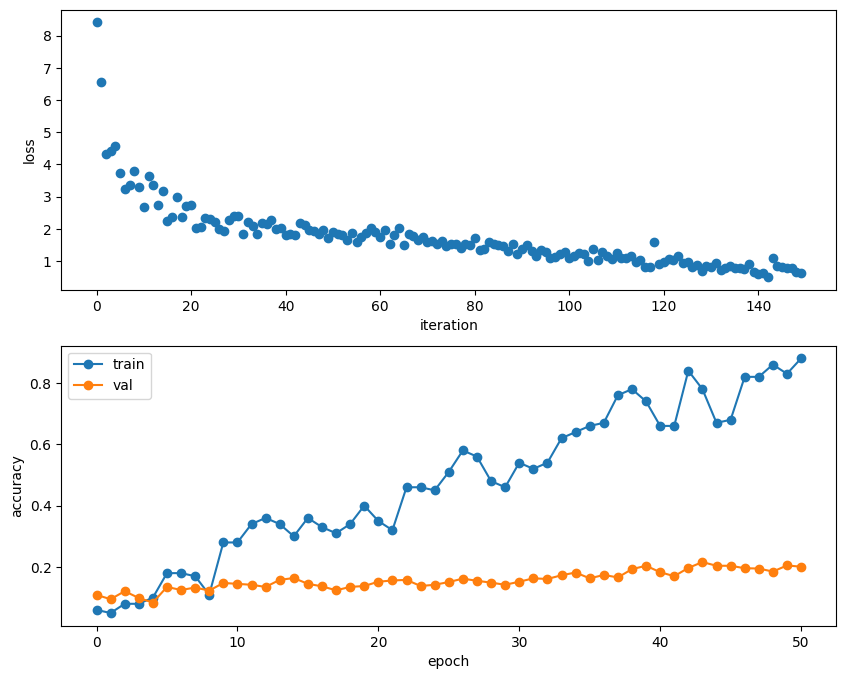

In [45]:
# Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

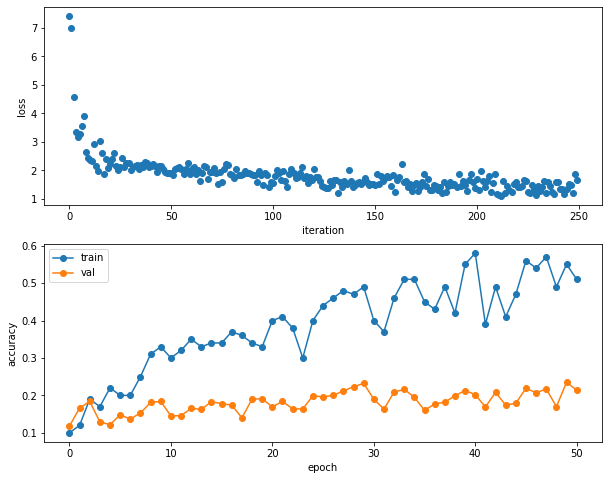

In [512]:
# Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

<font size='4' color='red'>**4.2: Train a good CNN (10 points).**
    
<font size='4'>By tweaking different hyper parameters, such as number of convolution layers, number of filters (channels), learning rate, batch size, etc, you should achieve greater than 62% accuracy on the validation set **with 3 epochs using the sgd_momentum optimizer**.
    
<font size='4'>If you are really careful, you should be able to get nearly 66% accuracy on the validation set. But we don't give extra credits for doing so.
    
<font size='4'>It may take a quite while for your training to be finished. **Do not use more than four convolution layers. Your training shouldn't be longer than one hour.** (This is a rough reference as it depends on the hardware. Our implementation takes less than 10 minutes to finish.)
    
<font size='4'>Use a large filter/kernel size in the first convolution layer (for example, 7), so you can easily visualize the learend filters.
    
<font size='4'>Since it is relatively slower to train a CNN, you can simply report the best hyper parameters you found. You need report validation accuracy of other choices below.
    
<font size='4' color='red'>For debuging purpose, you can simply train the model for a single epoch. As a reference, both your training and validation accuracy should be around 50% (could be slightly lower or higher). Once you figure a good setting, train the model for 3 epochs.

In [91]:
model = None
################################################################################
# TODO: Train the best ConvNet that you can on CIFAR-10 with 3 epochs using    #
# the sgd_momentum optimizer. Store your best model in the model variable.     #
################################################################################

np.random.seed(231)

num_train = 8000
data = {
  'X_train': data['X_train'],
  'y_train': data['y_train'],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ConvNet(
    num_filters=[16, 32, 128],
    filter_sizes=[7, 3, 3],
    weight_scale=.1,reg = .0005
)

solver = Solver(
    model, data,
    num_epochs=3, batch_size=32,
    update_rule='sgd_momentum',
    optim_config={
      'learning_rate': .05,
    },
    verbose=True, print_every=50
)
solver.train()

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

best_model = model
best_model.params.update(solver.best_params)

(Iteration 1 / 4593) loss: 2.448394
(Epoch 0 / 3) train acc: 0.109000; val_acc: 0.102000
(Iteration 51 / 4593) loss: 2.254845
(Iteration 101 / 4593) loss: 2.195288
(Iteration 151 / 4593) loss: 2.089300
(Iteration 201 / 4593) loss: 1.884766
(Iteration 251 / 4593) loss: 2.008223
(Iteration 301 / 4593) loss: 1.879414
(Iteration 351 / 4593) loss: 2.076048
(Iteration 401 / 4593) loss: 1.980644
(Iteration 451 / 4593) loss: 1.997160
(Iteration 501 / 4593) loss: 1.837994
(Iteration 551 / 4593) loss: 1.686793
(Iteration 601 / 4593) loss: 1.852982
(Iteration 651 / 4593) loss: 1.803251
(Iteration 701 / 4593) loss: 1.474096
(Iteration 751 / 4593) loss: 1.838442
(Iteration 801 / 4593) loss: 1.754557
(Iteration 851 / 4593) loss: 1.745185
(Iteration 901 / 4593) loss: 1.407363
(Iteration 951 / 4593) loss: 1.733720
(Iteration 1001 / 4593) loss: 1.623150
(Iteration 1051 / 4593) loss: 1.639843
(Iteration 1101 / 4593) loss: 1.817991
(Iteration 1151 / 4593) loss: 1.501586
(Iteration 1201 / 4593) loss: 1.60

In [94]:
# Run your best model on the validation and test sets. You should achieve above 62% accuracy on the validation set.
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.394
Test set accuracy:  0.404


### Visualize Filters

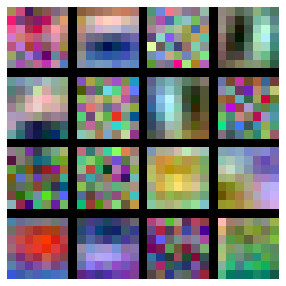

In [95]:
# You can visualize the first-layer convolutional filters from the trained network by running the following:
from utils.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

<font size='4' color='red'>**Task 4.3: report validation accuray for other hyper parameters you have tried (2 points)**

Kernels: 16XCX7X7, learning rate: .001,weight: .1, Validation accuracy: .271

Kernels: 16XCX7X7, learning rate: .0675,weight: .75, Validation accuracy: .419

Kernels: 16XCX7X7,16XCX3X3,16XCX3X3, learning rate: .0675,weight: .75, Validation accuracy: .385

Kernels: 16XCX7X7,16XCX3X3,16XCX3X3, learning rate: .05,weight: .1, Validation accuracy: .394


<font size='4' color='red'>**Task 4.4: train a ConvNet without using batch normalization layers (4 points).**
    
<font size='4'>Report the best validation accuracy you can get and discuss how it is different from the version with batch normalization layers.

Validation accuracy for the best performed aboce network

Kernels: 16XCX7X7, learning rate: .0675,weight: .75, No Batch Normalization, Validation accuracy: .173

The network had a higher learning rate so it kept overshooting and it caused to have lower accuracy